In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random, json, time, datetime, os, torch, nltk
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config
from transformers import AutoTokenizer, BloomForCausalLM, BloomConfig
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, random_split, DataLoader, RandomSampler, SequentialSampler

nltk.download('punkt')
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
model_name = 'bigscience/bloom-560m'
# model_name = 'akahana/gpt2-indonesia'
# model_name = 'EleutherAI/gpt-neo-125M'
# model_name = 'cahya/gpt2-small-indonesian-522M' 
epochs = 100
batch_size = 8
max_length = 100
warmup_steps = 1e2
sample_every = 100
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
output_dir = "/kaggle/working/"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
# def load_model_tokenizer(model_name_or_dir):
#     bos_token,eos_token,pad_token = '','',''
#     if model_name_or_dir == 'gpt2':
#         bos_token,eos_token,pad_token='<|startoftext|>','<|endoftext|>','<|pad|>'
#     if '/' in model_name_or_dir:
#         # Load from directory if it's a path
#         model = GPT2LMHeadModel.from_pretrained(model_name_or_dir)
#         tokenizer = GPT2Tokenizer.from_pretrained(model_name_or_dir)
#     else:
#         # Load from Hugging Face's model hub if it's a name
#         tokenizer = GPT2Tokenizer.from_pretrained(model_name_or_dir,
#                                                   bos_token=bos_token,
#                                                   eos_token=eos_token,
#                                                   pad_token=pad_token)
#         config = GPT2Config.from_pretrained(model_name_or_dir)
#         model = GPT2LMHeadModel.from_pretrained(model_name_or_dir, config=config)
#         model.resize_token_embeddings(len(tokenizer))

#     # Move model to GPU if available
#     model = model.to(device)

#     return model, tokenizer

In [4]:
def load_model_tokenizer(model_name_or_dir, ablated_component=None):
    bos_token,eos_token,pad_token='<|startoftext|>','<|endoftext|>','<|pad|>'
    # Load from Hugging Face's model hub if it's a name
    tokenizer = AutoTokenizer.from_pretrained(model_name_or_dir,
                                              bos_token=bos_token,
                                              eos_token=eos_token,
                                              pad_token=pad_token)
    config = BloomConfig.from_pretrained(model_name_or_dir)
    if ablated_component == 'attention_heads':
        # Ablate attention heads
        config.num_attention_heads = 16
#         config.hidden_size = 1280
#         config.embed_dim = 1280
    elif ablated_component == 'layers':
        # Ablate layers
        config.num_hidden_layers = 2
    model = BloomForCausalLM.from_pretrained(model_name_or_dir, config=config)
    model.resize_token_embeddings(len(tokenizer))

    # Move model to GPU if available
    model = model.to(device)
    tokenizer.pad_token = tokenizer.eos_token

    return model, tokenizer

In [5]:
model, tokenizer = load_model_tokenizer(model_name,'layers')
print(sum(p.numel() for p in model.parameters()) / 1e6, 'M parameters')
print(model)

tokenizer_config.json:   0%|          | 0.00/222 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of the model checkpoint at bigscience/bloom-560m were not used when initializing BloomForCausalLM: ['h.10.input_layernorm.bias', 'h.10.input_layernorm.weight', 'h.10.mlp.dense_4h_to_h.bias', 'h.10.mlp.dense_4h_to_h.weight', 'h.10.mlp.dense_h_to_4h.bias', 'h.10.mlp.dense_h_to_4h.weight', 'h.10.post_attention_layernorm.bias', 'h.10.post_attention_layernorm.weight', 'h.10.self_attention.dense.bias', 'h.10.self_attention.dense.weight', 'h.10.self_attention.query_key_value.bias', 'h.10.self_attention.query_key_value.weight', 'h.11.input_layernorm.bias', 'h.11.input_layernorm.weight', 'h.11.mlp.dense_4h_to_h.bias', 'h.11.mlp.dense_4h_to_h.weight', 'h.11.mlp.dense_h_to_4h.bias', 'h.11.mlp.dense_h_to_4h.weight', 'h.11.post_attention_layernorm.bias', 'h.11.post_attention_layernorm.weight', 'h.11.self_attention.dense.bias', 'h.11.self_attention.dense.weight', 'h.11.self_attention.query_key_value.bias', 'h.11.self_attention.query_key_value.weight', 'h.12.input_layernorm.bias', 'h.12.

281.895936 M parameters
BloomForCausalLM(
  (transformer): BloomModel(
    (word_embeddings): Embedding(250683, 1024)
    (word_embeddings_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (h): ModuleList(
      (0-1): 2 x BloomBlock(
        (input_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (self_attention): BloomAttention(
          (query_key_value): Linear(in_features=1024, out_features=3072, bias=True)
          (dense): Linear(in_features=1024, out_features=1024, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (post_attention_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): BloomMLP(
          (dense_h_to_4h): Linear(in_features=1024, out_features=4096, bias=True)
          (gelu_impl): BloomGelu()
          (dense_4h_to_h): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwis

In [6]:
# # model = GemmaModel.from_pretrained("hf-internal-testing/dummy-gemma")
# # tokenizer = GemmaTokenizerFast.from_pretrained("hf-internal-testing/dummy-gemma")
# tokenizer = AutoTokenizer.from_pretrained("bigscience/bloom-560m")
# model = BloomForCausalLM.from_pretrained("bigscience/bloom-560m")
# tokenizer.pad_token = tokenizer.eos_token
# print(sum(p.numel() for p in model.parameters()) / 1e6, 'M parameters')

In [7]:
df = pd.read_csv('/kaggle/input/dataset-pantun-indonesia/dataset-pantun.csv')
df = df[['teks','tipe']]
df

,teks,tipe
0,Ada motor ada sepeda \n Semuanya beroda dua \n Indonesia kaya budaya \n Sepatutnya kita menjaganya,Pantun Adat dan Alam
1,Ada pisang ada semangka \n Jika dimakan manis rasanya \n Indonesia ragam budaya \n Tugas kita tuk menjaganya,Pantun Adat dan Alam
2,Ada rusa ada buaya \n Sungguh hitam warna matanya \n Ada adat seribu bahasa \n Kita wajib menghormatinya,Pantun Adat dan Alam
3,Alat timbang pucuknya patah \n Beli baru hendak dipesan \n Alam terkembang amat indah \n Dipandang-pandang tiada bosan,Pantun Adat dan Alam
4,Anak cina makan petai \n Kakinya terikat rantai \n Lihatlah indahnya pantai \n Membuat jiwa terasa santai,Pantun Adat dan Alam
...,...,...
1445,Jalan-jalan ke surabaya \n Pulangnya beli hadiah \n Jika ingin cepat kaya \n Tidak susah tinggal sedekah,NaN
1446,Hari malam gelap-gelita \n Pasang lilin jalan ke taman \n Sopan santun budaya kita \n Jadi kebanggaan zaman berzaman,NaN
1447,Apa guna berkain batik \n Kalau tidak dengan sucinya? \n Apa guna beristeri cantik \n Kalau tidak dengan budinya,NaN
1448,Buah cempedak di luar pagar \n Ambil galah tolong jolokkan \n Saya budak baru belajar \n Kalau salah tolong tunjukkan,NaN


In [8]:
print(df[df['teks'].str.contains("Di kamar tidur teronggok cermin")]['teks'])

452    Di kamar tidur teronggok cermin \n Cermin dipakai untuk berdandan \n Di tanah lapang kami bermain \n Bermain gundu juga layangan
Name: teks, dtype: object


In [9]:
# Convert data to list of dictionaries
formatted_data = []
for idx, row in df.iterrows():
    formatted_data.append({'id': idx, 'poem': row['teks']})

formatted_data[0:5]

[{'id': 0,
  'poem': 'Ada motor ada sepeda \\n Semuanya beroda dua \\n Indonesia kaya budaya \\n Sepatutnya kita menjaganya'},
 {'id': 1,
  'poem': 'Ada pisang ada semangka \\n Jika dimakan manis rasanya \\n Indonesia ragam budaya \\n Tugas kita tuk menjaganya'},
 {'id': 2,
  'poem': 'Ada rusa ada buaya \\n Sungguh hitam warna matanya \\n Ada adat seribu bahasa \\n Kita wajib menghormatinya'},
 {'id': 3,
  'poem': 'Alat timbang pucuknya patah \\n Beli baru hendak dipesan \\n Alam terkembang amat indah \\n Dipandang-pandang tiada bosan'},
 {'id': 4,
  'poem': 'Anak cina makan petai \\n Kakinya terikat rantai \\n Lihatlah indahnya pantai \\n Membuat jiwa terasa santai'}]

In [10]:
data = formatted_data

In [11]:
class PoemDataset(Dataset):
    def __init__(self, poems, tokenizer, max_length=768):
        self.tokenizer = tokenizer
        self.input_ids = []
        self.attn_masks = []

        for poem in poems:

            encodings_dict = tokenizer("<|startoftext|>"+poem["poem"]+"<|endoftext|>",
                                     truncation=True,
                                     max_length=max_length,
                                     padding="max_length")
#             encodings_dict = tokenizer(poem["poem"],
#                                      truncation=True,
#                                      max_length=max_length,
#                                      padding="max_length")

            self.input_ids.append(torch.tensor(encodings_dict["input_ids"]))
            self.attn_masks.append(torch.tensor(encodings_dict["attention_mask"]))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx]

In [12]:
print(tokenizer.encode("Hello World", padding="max_length", max_length=10))
print(len(tokenizer))

[250681, 250681, 250681, 250681, 250681, 250681, 250681, 250681, 59414, 12155]
250683


In [13]:
print(tokenizer.encode("<|startoftext|> Hello World <|endoftext|>", padding="max_length", max_length=10))
print(len(tokenizer))

[250681, 250681, 250681, 250681, 250681, 250680, 86153, 12155, 210, 250681]
250683


In [14]:
print(tokenizer.encode("<s> Hello World </s>", padding="max_length", max_length=10))
print(len(tokenizer))

[250681, 250681, 250681, 250681, 250681, 1, 86153, 12155, 210, 2]
250683


In [15]:
# Finding length of maximum token in dataset
max_length = max([len(tokenizer.encode(poem["poem"])) for poem in data])
print(max_length)
max_length = 100

58


In [16]:
x = [len(tokenizer.encode(poem["poem"])) for poem in data if len(tokenizer.encode(poem["poem"])) < 100]

In [17]:
y = [len(tokenizer.encode(poem["poem"])) - len(poem["poem"].split()) for poem in data]

In [18]:
print(sum(y)/len(y))

6.224827586206897


58 1450


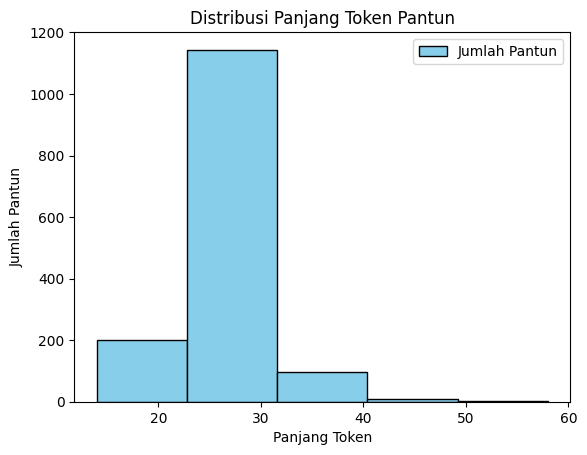

In [19]:
print(max(x), len(x))
# Plotting histogram
plt.hist(x, bins=5, color='skyblue', edgecolor='black')
plt.title('Distribusi Panjang Token Pantun')
plt.xlabel('Panjang Token')
plt.ylabel('Jumlah Pantun')
plt.legend(['Jumlah Pantun'])
plt.show()

In [20]:
dataset = PoemDataset(data, tokenizer, max_length=max_length)

# Split data into train and validation sets
train_size = int(0.9*len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
print("Number of samples for training =", train_size)
print("Number of samples for validation =", val_size)

Number of samples for training = 1305
Number of samples for validation = 145


In [21]:
train_dataset[0]

(tensor([250681, 250681, 250681, 250681, 250681, 250681, 250681, 250681, 250681,
         250681, 250681, 250681, 250681, 250681, 250681, 250681, 250681, 250681,
         250681, 250681, 250681, 250681, 250681, 250681, 250681, 250681, 250681,
         250681, 250681, 250681, 250681, 250681, 250681, 250681, 250681, 250681,
         250681, 250681, 250681, 250681, 250681, 250681, 250681, 250681, 250681,
         250681, 250681, 250681, 250681, 250681, 250681, 250681, 250681, 250681,
         250681, 250681, 250681, 250681, 250681, 250681, 250681, 250681, 250681,
         250681, 250681, 250681, 250681, 250681, 250680,  41476, 125061,  61731,
            677,   9870, 128689,  96221,  49132,   8883,    363,  31957,  93761,
          14349, 207164,  49132,  51191,  10794,   3155,    348, 240953,   4099,
           5173,  49132,   5021,   8329,  32935,   5841,   4929,   7914, 198929,
         250681]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         

In [22]:
train_dataloader = DataLoader(train_dataset,
                              sampler=RandomSampler(train_dataset),
                              batch_size=batch_size)

val_dataloader = DataLoader(val_dataset,
                            sampler=SequentialSampler(val_dataset),
                            batch_size=batch_size)

print(len(train_dataloader))
print(len(train_dataset))

164
1305


In [23]:
# Using AdamW optimizer with default parameters
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, eps=1e-8)

# Toatl training steps is the number of data points times the number of epochs
total_training_steps = len(train_dataloader)*epochs

# Setting a variable learning rate using scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=warmup_steps,
                                            num_training_steps=total_training_steps)

In [24]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round(elapsed))))

In [25]:
total_t0 = time.time()
training_stats = []
model = model.to(device)

for epoch_i in range(epochs):
    print(f'Beginning epoch {epoch_i+1} of {epochs}')

    t0 = time.time()
    total_train_loss = 0
    model.train()

    # Labels are shifted by 1 timestep
    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(b_input_ids,
                        labels=b_labels,
                        attention_mask=b_masks)

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Sampling every x steps
        if step != 0 and step % sample_every == 0:

            elapsed = format_time(time.time()-t0)
            print(f'Batch {step} of {len(train_dataloader)}. Loss: {batch_loss}. Time: {elapsed}')

            model.eval()

            sample_outputs = model.generate(
                bos_token_id=random.randint(1,30000),
                do_sample=True,
                top_k=50,
                max_length=200,
                top_p=0.95,
                num_return_sequences=1
            )
            for i, sample_output in enumerate(sample_outputs):
                print(f'Example ouput: {tokenizer.decode(sample_output, skip_special_tokens=True)}')
            print()

            model.train()

        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = format_time(time.time()-t0)
    print(f'Average Training Loss: {avg_train_loss}. Epoch time: {training_time}')
    print()

    t0 = time.time()
    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in val_dataloader:
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():

            outputs  = model(b_input_ids,
                             attention_mask=b_masks,
                             labels=b_labels)

            loss = outputs[0]

        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(val_dataloader)
    val_time = format_time(time.time() - t0)
    print(f'Validation loss: {avg_val_loss}. Validation Time: {val_time}')
    print()

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': val_time
        }
    )
    print("------------------------------")

print(f'Total training took {format_time(time.time()-total_t0)}')

Beginning epoch 1 of 100
Batch 100 of 164. Loss: 2.8305552005767822. Time: 0:00:26
Example ouput:  μatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatatat

Average Training Loss: 10.425792782044992. Epoch time: 0:00:43

Validation loss: 2.3216793160689506. Validation Time: 0:00:01

------------------------------
Beginning epoch 2 of 100
Batch 100 of 164. Loss: 1.539774775505066. Time: 0:00:25
Example ouput: 准ilahilahilahilah kita \n Indah ibu ibu ibu ibu ibu ibu ibu ibu ibu Ibu

Average Training Loss: 1.7381266515429428. Epoch time: 0:00:42

Validation loss: 1.871589654370358. Validation Time: 0:00:01

------------------------------
Beginning epoch

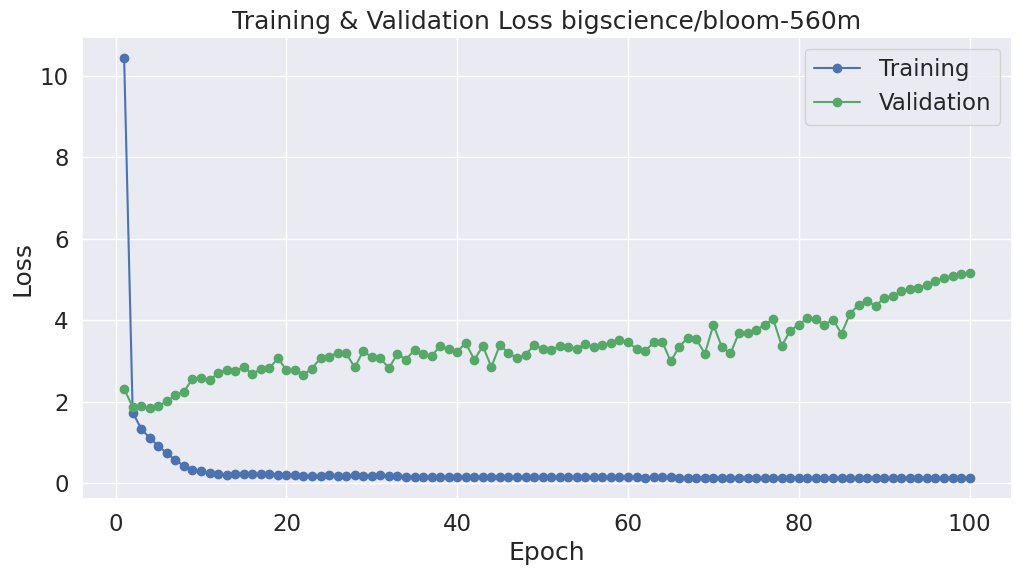

In [26]:
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title(f"Training & Validation Loss {model_name}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('loss_plot.png')
plt.show()

In [27]:
model.eval()

prompt = "<|startoftext|>"
# prompt = "<s>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = model.generate(
                                generated,
                                do_sample=True,
                                top_k=50,
                                max_length = 300,
                                top_p=0.95,
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
    print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

0: Ada gula ada kopi \n Disimpan di atas lemari \n Rindu ini menari-nari \n Menanti sang pujaan hati


1: Punya istri cuma satu \n dia malah seorang penjual jamu \n Aku ingin ungkapkan sesuatu \n yaitu aku ingin mendapatkan cinta yang tulus darimu


2: Malam-malam pergi ke dukun \n Pulangnya beli terasi \n Jika ingin hidup rukun \n Budayakan bertoleransi




In [28]:
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('/kaggle/working/tokenizer_config.json',
 '/kaggle/working/special_tokens_map.json',
 '/kaggle/working/tokenizer.json')

In [29]:
# Save generated poems
sample_outputs = model.generate(
                                generated,
                                do_sample=True,
                                top_k=50,
                                max_length = 300,
                                top_p=0.95,
                                num_return_sequences=25
                                )

with open(os.path.join(output_dir, 'generated_poems.txt'), "w") as outfile:
    for i, sample_output in enumerate(sample_outputs):
        outfile.write(tokenizer.decode(sample_output, skip_special_tokens=True)+"\n\n")

In [30]:
def lexical_richness(text):
    tokens = nltk.word_tokenize(text.lower())
    unique_tokens = set(tokens)
    return (len(unique_tokens) / len(tokens)) * 100

def calculate_richness_score(pantun_list):
    richness_scores = [lexical_richness(pantun) for pantun in pantun_list]
    return sum(richness_scores) / len(richness_scores)

def calculate_structure_accuracy(pantun_list):
    correct_structure_count = 0
    total_pantun_count = len(pantun_list)
    for pantun in pantun_list:
        # Check if the pantun has correct structure
        if len(pantun.split('\\n')) == 4:
            correct_structure_count += 1
    structure_accuracy = correct_structure_count / total_pantun_count*100
    return structure_accuracy

def rhyme_check(pantun):
    # Memisahkan setiap baris pantun
    lines = pantun.split("\\n")
    
    # Mengambil kata terakhir dari setiap baris (jika ada)
    last_words = [line.split()[-1].lower() if line.strip() else "" for line in lines]
    
    # Mendefinisikan fungsi untuk mendapatkan vokal terakhir dari setiap kata
    def get_last_vowel(word):
        vowels = "aiueo"
        for char in reversed(word):
            if char.lower() in vowels:
                return char.lower()
        return None
    
    # Mendapatkan vokal terakhir dari setiap kata
    last_vowels = [get_last_vowel(word) for word in last_words]
    
    # Memeriksa kecocokan rima
    if len(last_vowels) == 4 and last_vowels[0] == last_vowels[2] and last_vowels[1] == last_vowels[3]:
        return 1
    else:
        return 0
    
def calculate_rhyme_correctness(pantuns):
    total_pantuns = len(pantuns)
    total_correct = 0
    
    for pantun in pantuns:
        if rhyme_check(pantun):
            total_correct += 1
    
    rhyme_correctness = (total_correct / total_pantuns) * 100
    return rhyme_correctness

In [31]:
# Membaca teks dari file
file_path = "/kaggle/working/generated_poems.txt"  # Ubah sesuai dengan path file Anda
with open(file_path, "r") as file:
    pantun_text = file.read()

# Memisahkan teks menjadi list tanpa karakter "\n"
pantun_list = pantun_text.split("\n")
pantun_list = [pantun for pantun in pantun_list if pantun.strip()]
# pantun_list = ["".join(pantun.split("\n")) for pantun in pantun_list]
# Menampilkan pantun dalam bentuk list
print(pantun_list)

['Sore-sore makan sekoteng \\n Belanjanya di pasar minggu \\n Abang sayang yang ganteng \\n Neng disini selalu menunggu', 'Hari panas minum blewah \\n Membasahi tenggorokan kering \\n Para petani turun ke sawah \\n Memetik padi yang menguning', 'Orang itu bukanlah hantu \\n tapi orang itu adalah tamu \\n Aku ingin menjadi kunci pintu \\n supaya aku dapat membuka pintu hatimu', 'Lihat pisang dimakan tupai \\n Burung bangau memakan ikan \\n Kalau perang sudah dimulai \\n Masa depan pun terabaikan', 'Jika kamu pergi ke gurun \\n Jangan lupa membawa beras \\n Jika kamu belajar tekun \\n Kamu pasti naik kelas', 'Menanam kelapa di pulau Bukum \\n Tinggi sedepa sudah berbuah \\n Adat bermula dengan hukum \\n Hukum bersandar di Kitabullah', 'Bunga cantik namanya seroja \\n Hewan cantik namanya rusa \\n Jalan-jalan ke mana saja \\n Pergi ke kota atau ke desa', 'Orang cerdas berinovatif \\n urang aring untuk berdandan \\n Yuk berfikir konservatif \\n Untuk bumi masa depan', 'Jika kamu pergi ke d

In [32]:
average_richness_score = calculate_richness_score(pantun_list)
print(f"Average Lexical Richness Score: {average_richness_score:.2f}%")

accuracy_score = calculate_structure_accuracy(pantun_list)
print(f"Structure Accuracy Score: {accuracy_score:.2f}%")

rhyme_correctness = calculate_rhyme_correctness(pantun_list)
print(f"Persentase Rhyme Correctness Score: {rhyme_correctness:.2f}%")

Average Lexical Richness Score: 82.78%
Structure Accuracy Score: 100.00%
Persentase Rhyme Correctness Score: 96.00%


In [33]:
# Hitung perplexity
perplexity_scores = []
for text in pantun_list:
    input_ids = tokenizer.encode(text, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
    loss = outputs.loss
    perplexity = torch.exp(loss)
    perplexity_scores.append(perplexity.item())

print("Average Perplexity Scores:", np.mean(perplexity_scores))

Average Perplexity Scores: 1.7619733428955078
